# BT2 - RANSAC y Transformada de Hough

## Autores

* **Juan Diego Gallego Nicolás (jdiego.gallego@um.es)**
* **Óscar Vera López (oscar.veral@um.es)**
  
## Fecha

**2 de Noviembre de 2025**

***

## Índice

### 1. Introducción al notebook

### 2. Configuración e inicialización

* 2.1. Importación de librerías
* 2.2. Definición de funciones auxiliares
* 2.3. Presentación y preprocesado de las imágenes

### 3. Detección de bordes

* 3.1. Operador de Canny
* 3.2. Segmentación por color y dilatación
* 3.3. Comparación de los resultados

### 4. Detección de features con RANSAC

* 4.1. Detección de rectas
* 4.2. Detección de segmentos
* 4.3. Detección de circunferencias
* 4.4. Puesta en común

### 5. Análisis

* 5.1. Análisis del rendimiento de RANSAC para rectas
* 5.2. Análisis de la convergencia de RANSAC para rectas

### 6. Conclusiones

### Uso de IA

### Bibliografía

***

# 1. Introducción al notebook

Este notebook es la segunda parte de una serie de cinco que constituye nuestra práctica para la asignatura de Visión Artificial del Máster en Inteligencia Artificial de la Universidad de Murcia. Alguno de los métodos/resultados que aquí se utilizan pueden estar comentados en un notebook anterior. Para el correcto funcionamiento del mismo es necesario instalar el paquete del proyecto siguiendo las instrucciones del [repositorio de GitHub](https://github.com/oscarveral/vision.git).

Aquí tratamos la detección de rectas y de otras formas geométricas características en el ámbito de las señales de tráfico, candidatas idóneas sobre el papel para aplicar las técnicas vistas en la asignatura. Comenzamos presentando el conjunto de imágenes que servirán como objeto para la aplicación de **RANSAC** (Random Sample Consensus). Seguidamente pasamos a la preparación y transformación de las imágenes mediante la aplicación del pipeline propuesto e implementado en el notebook BT1 para el **operador de Canny**. También propinemos otro técnica de detección de bordes basado en la segmentación por color de las señales. Los siguientes puntos contienen la explicación y aplicación de nuestras implementaciones de RANSAC para la detección de rectas, segmentos y circunferencias. 

Al final del documento, incluimos un apartado de conclusiones y justificación de los ítems de bloques cubiertos por nuestro trabajo. También dejamos un párrafo explicando el papel de la IA generativa en la elaboración del mismo.

# 2. Configuración e inicialización

## 2.1. Importación de librerías

En el siguiente fragmento de código se incluyen las importaciones necesarias para la ejecución de todos los bloques de código del notebook. Recuerde crear un entorno virtual con el proyecto instalado (Ejecutar "pip install -e ." en el directorio raíz del proyecto) y seguir las instrucciones del fichero README.md.

In [1]:
# Imports de python
import time

# Librerías de terceros
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Librerías propias
from dgst.utils.loader import *
from dgst.utils.processor import *
from dgst.utils.features import *


## 2.2. Definición de funciones auxiliares

A continuación incluimos las definiciones de una serie de funciones para simplificar la salida de las celdas del notebook.

In [2]:
# Función para mostrar las imágenes en una cuadrícula
def plot_images(images, titles=None, grid_shape=(3, 4), figsize=None):
    if figsize is None:
        figsize = (grid_shape[1]*3, grid_shape[0]*2)
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            image = images[i]
            if not isinstance(images[i], np.ndarray):
                image = images[i].get_image()
        
            if (image.ndim == 2):
                ax.imshow(image, cmap='gray')
            else:
                ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            if titles:
                ax.set_title(titles[i])
            else:
                ax.set_title(f'Image {i}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Función para mostrar las imágenes en una cuadrícula intercalando imágenes de diferentes listas
def intercalate_images(images_matrix, titles=None, grid_shape=(3, 4), figsize=None):
    intercalated_images = []
    intercalated_titles = []
    n_lists = len(images_matrix)
    n_images = len(images_matrix[0])
    idx = 0
    # Intercambiamos los índices para intercalar las imágenes
    for i in range(n_images):
        for j in range(n_lists):
            intercalated_titles.append(titles[j] + str(idx))
            intercalated_images.append(images_matrix[j][i])
        idx += 1

    plot_images(intercalated_images, intercalated_titles, grid_shape, figsize)

# Función para filtrar las señales por su espacio de color.
# La imagen entra en formato HSV
def filter_signs(img, kernel_size=None):
    # Red color (two ranges)
    lower_red1 = (0, 90, 50)
    upper_red1 = (10, 255, 210)
    lower_red2 = (165, 90, 50)
    upper_red2 = (179, 255, 210)

    # Blue color 
    lower_blue = (90, 90, 50)
    upper_blue = (130, 255, 210)
    
    mask_red1 = cv.inRange(img, lower_red1, upper_red1)
    mask_red2 = cv.inRange(img, lower_red2, upper_red2)
    mask_blue = cv.inRange(img, lower_blue, upper_blue)
    
    mask_combined = mask_red1 | mask_red2 | mask_blue
    
    return mask_combined

def paint_lines_on_image(lines, image, color='red'):
    image_with_lines = image.copy()
    if (image.ndim == 2):
        image_with_lines = cv.cvtColor(image_with_lines, cv.COLOR_GRAY2BGR)
    height, width = image.shape[:2]
    for line in lines:
        a, b, c = line
        if (b < 1e-6 and b > -1e-6):
            # Hay linea vertical
            y_vals = np.array([0, height - 1])
            x_vals = np.array([-c / a, -c / a])
        elif (a < 1e-6 and a > -1e-6):
            # Hay linea horizontal
            x_vals = np.array([0, width - 1])
            y_vals = np.array([-c / b, -c / b])
        else:
            # Calculamos dos puntos en los extremos de la imagen
            x_vals = np.array([0, width - 1])
            y_vals = (-a * x_vals - c) / b
            if (y_vals[0] < 0):
                y_vals[0] = 0
                x_vals[0] = (-b * y_vals[0] - c) / a
            elif (y_vals[0] >= height):
                y_vals[0] = height - 1
                x_vals[0] = (-b * y_vals[0] - c) / a
            if (y_vals[1] < 0):
                y_vals[1] = 0
                x_vals[1] = (-b * y_vals[1] - c) / a
            elif (y_vals[1] >= height):
                y_vals[1] = height - 1
                x_vals[1] = (-b * y_vals[1] - c) / a
        pt1 = (int(round(x_vals[0])), int(round(y_vals[0])))
        pt2 = (int(round(x_vals[1])), int(round(y_vals[1])))
        cv.line(image_with_lines, pt1, pt2, color, 2)
    return image_with_lines

def paint_segments_on_image(segments, image, color='blue'):
    image_with_segments = image.copy()
    if (image.ndim == 2):
        image_with_segments = cv.cvtColor(image_with_segments, cv.COLOR_GRAY2BGR)
    for segment in segments:
        (start_x, start_y), (end_x, end_y) = segment
        pt1 = (int(round(start_x)), int(round(start_y)))
        pt2 = (int(round(end_x)), int(round(end_y)))
        cv.line(image_with_segments, pt1, pt2, color, 2)
    return image_with_segments

def paint_circles_on_image(circles, image, color='green'):
    image_with_circles = image.copy()
    if (image.ndim == 2):
        image_with_circles = cv.cvtColor(image_with_circles, cv.COLOR_GRAY2BGR)
    for circle in circles:
        x, y, r = circle
        center = (int(round(x)), int(round(y)))
        radius = int(round(r))
        cv.circle(image_with_circles, center, radius, color, 2)
    return image_with_circles

## 2.3. Presentación y preprocesado de las imágenes

Hemos seleccionado un subconjunto de 11 imágenes del dataset presentado en el notebook BT1. En todas las imágenes aparecen señales de tráfico con diferentes geometrías, algunas más cercanas a la cámara y otras más alejadas. Las encontramos dentro de la carpeta `notebooks/images/bt2`.



In [3]:
data_loader = DataLoader('./images/bt2')

images = []
for idx in [14, 177, 205, 247, 20539, 20541, 20567, 20578, 20579, 20604, 30352]:
    image = data_loader.load(idx)
    images.append(image)

# plot_images(images, grid_shape=(3, 4), figsize=(12,6))

Loading image from ./images/bt2/000014/camera_front_blur/000014_india_2021-04-18T15:57:58.885517Z.jpg
Loading image from ./images/bt2/000177/camera_front_blur/000177_golf_2021-04-26T09:01:16.995578Z.jpg
Loading image from ./images/bt2/000205/camera_front_blur/000205_india_2021-04-29T13:26:40.774894Z.jpg
Loading image from ./images/bt2/000247/camera_front_blur/000247_golf_2021-04-27T10:58:38.108810Z.jpg
Loading image from ./images/bt2/020539/camera_front_blur/020539_india_2020-04-24T13:34:24.775134Z.jpg
Loading image from ./images/bt2/020541/camera_front_blur/020541_india_2020-03-31T11:09:20.113995Z.jpg
Loading image from ./images/bt2/020567/camera_front_blur/020567_india_2020-07-27T13:01:18.890907Z.jpg
Loading image from ./images/bt2/020578/camera_front_blur/020578_oscar_2021-04-15T08:41:33.109881Z.jpg
Loading image from ./images/bt2/020579/camera_front_blur/020579_india_2020-07-22T08:47:24.215579Z.jpg
Loading image from ./images/bt2/020604/camera_front_blur/020604_golf_2021-02-23T14:0

Como observamos, las imágenes sufren de una acusada distorsión de ojo de pez que ya comentamos en el notebook anterior. Este fenómeno dificultaría enormemente la aplicación de técnicas clasicas de detección de rectas. Por tanto, aplicamos el algoritmo de rectificación.

In [4]:
# Rectificamos las imágenes
rectified_images = []
for image in images:
    processor = (ImageProcessor()
        .add_kannala_brandt_undistortion()
    )
    rectified_image = processor.process(image)
    rectified_images.append(rectified_image)

print("Cada imagen rectificada tiene un tamaño de:", rectified_images[0].data.shape)

Cada imagen rectificada tiene un tamaño de: (2168, 3848, 3)


In [ ]:
# Mostramos las imágenes rectificadas
plot_images(rectified_images, grid_shape=(3, 4), figsize=(12,6))

El efecto es evidente, por ejemplo, en el salpicadero del coche. Otra consecuencia del filtro es la desaparición de los bordes de la imagen, aunque la resolución de las mismas se mantiene. 

Por motivos de eficiencia y para facilitar la visualización de los bordes posteriormente, reescalamos las imágenes en un factor de 0.5 mediante el algoritmo cv.INTER_AREA [[1]](#Bibliografía) de OpenCV, ideal para reducir imágenes.

In [6]:
images_scaled = []

processor = ImageProcessor().add_scale_inter_area(0.5)

for image in rectified_images:
    image = processor.process(image)
    images_scaled.append(image)

Una vez que contamos con las imágenes reducidas, aplicamos una reducción de ruido mediante un filtro de medianas, que mitiga el ruido de sal y pimienta tan presente en las grabaciones de dashcams mientras preservamos bordes.

In [7]:
filtered_images = []

processor = ImageProcessor().add_median_blur(5)

for img in images_scaled:
    filtered_img = processor.process(img)
    filtered_images.append(filtered_img)

In [ ]:
plot_images(filtered_images, grid_shape=(3, 4))

Finalmente, renombranos la lista por comodidad.

In [9]:
images = filtered_images

# 3. Detección de bordes

Antes de aplicar cualquier algoritmo de detección de formas geométricas es necesario usar en primer lugar un filtro de detección de bordes. En esta sección comparamos un filtro de bordes generalista clásico como lo puede ser el **operador de Canny** [[2]](#Bibliografía) visto en BT1 con una implementación basada en segmentación por color aprovechando la naturaleza del problema.

 HSV [[3]](https://en.wikipedia.org/wiki/HSL_and_HSV) alude a las siglas Hue/Saturation/Value. Las señales de tráfico son objetos que deben ser fácilmente detectados por el ojo humano, contando con colores característicos y saturados para diferenciarlos del entorno. Podemos visualizar la descomposición en dichos canales para alguna de nuestras imágenes:

In [10]:
processor = ImageProcessor().add_into_hsv_channels()
images_hsv = [processor.process(img) for img in images]

In [ ]:
intercalate_images(
    images_matrix=[
        images,
        [img.get_hsv_channel('H') for img in images_hsv],
        [img.get_hsv_channel('S') for img in images_hsv],
        [img.get_hsv_channel('V') for img in images_hsv]
    ],
    titles=['Original Image ', 'Hue Channel ', 'Saturation Channel ', 'Value Channel '],
    grid_shape=(11, 4),
    figsize=(20, 40)
)

Resulta evidente la importancia del canal de saturación a la hora de detectar las señales, pues destacan en la mayoría de los casos. También destaca el canal de matiz, que es divide la imagen por color, de forma que los tonos más oscuros y mas brillantes son rojos y los medios-altos son azules. El último canal, el de valor o brillo, es la clásica representación de la imagen en escala de grises.

La última imagen está escogida a drede para servir como posible caso de fallo para las técnicas que aquí aplicamos, pues es una imagen tomada de noche y muy saturada.


# 3.1. Operador de Canny

El detector de bordes de Canny [[2]](https://doi.org/10.1109/TPAMI.1986.4767851) es la herramienta más extendida en este ámbito dada su base matemática y su efectividad. En este notebook vamos a usar la implementación propia que comentábamos en el previo BT1. Como indicábamos, abarcamos desde la aplicación del filtro de Sobel para el cálculo de las derivadas direccionales y no aplica el filtro de suavizado previo. En la documentación de [OpenCV](https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de) no queda claro en qué magnitud aplica el filtro gaussiano, así que nosotros vamos a utilizar un kernel de $\sigma=0.4$ ya que es el que mejor nos funciona. 

Comenzamos declarando el procesador de imágenes que usaremos en esta sección.

In [12]:
canny_processor = (ImageProcessor()
    .add_clahe()
    .add_gaussian_filter(sigma=0.4, on_hsv=True)
    .add_canny_edge_detection(low_threshold=150, high_threshold=250, on_hsv=True)
    .add_dilate_edges(kernel_size=3, iterations=2, on_hsv=True)
)

Probamos el detecctor de canny sobre los tres canales HSV

In [13]:
canny_h = []
canny_s = []
canny_v = []
for img in images_hsv:
    res = canny_processor.process(img)
    canny_h.append(res.get_hsv_channel('H'))
    canny_s.append(res.get_hsv_channel('S'))
    canny_v.append(res.get_hsv_channel('V'))


Y mostramos los resultados a los que se le ha aplicado una pequeña dilatación para facilitar la visualización.

In [ ]:
intercalate_images(
    images_matrix=[
        images,
        canny_h,
        canny_s,
        canny_v
    ],
    titles=['Original Image ', 'Canny on H Image ', 'Canny on S Image ', 'Canny on V Image '],
    grid_shape=(11, 4),
    figsize=(20, 40)
)

Vemos como claramente el canal de saturación (S) es el que mejores resultados ofrece para la detección de bordes en las señales de tráfico, especialmente en las señales rojas y azules. El canal de matiz (H) también ofrece buenos resultados en algunas señales captando, por ejemplo, las señales de obras de la imagen 4; pero en general es menos consistente que el canal de saturación.

Podemos realizar una última prueba aplicando el filtro a una combinación ponderada de ambos canales:

In [15]:
img_hs = []
canny_hs = []
s_weight = 0.75

fuse_hs = ImageProcessor().add_channel_weight('H', 'S', s_weight)

canny_hs_proc = (ImageProcessor()
    .add_gaussian_filter(sigma=0.4)
    .add_canny_edge_detection(low_threshold=150, high_threshold=250)
    .add_dilate_edges(kernel_size=3, iterations=2)
)

for img in images_hsv:
    hs_channel = fuse_hs.process(img)
    img_hs.append(hs_channel)
    canny_mask_hs = canny_hs_proc.process(hs_channel)
    canny_hs.append(canny_mask_hs)

In [ ]:
intercalate_images(
    images_matrix=[
        images,
        img_hs,
        canny_hs
    ],
    titles=['Original Image ', 'HS Combined Channel ', 'Canny on HS Channel '],
    grid_shape=(11, 3),
    figsize=(15, 40)
)

La proporción 25-75 es la que mejor balancea los artefactos detectados en cada uno de los parámetros probados.

Terminamos este apartado renombrando la lista de bordes de Canny.

In [17]:
img_hs = []
canny = []
s_weight = 0.75

fuse_hs = ImageProcessor().add_channel_weight('H', 'S', s_weight)

canny_hs_proc = (ImageProcessor()
    .add_gaussian_filter(sigma=0.4)
    .add_canny_edge_detection(low_threshold=150, high_threshold=250)
)

for img in images_hsv:
    hs_channel = fuse_hs.process(img)
    img_hs.append(hs_channel)
    canny_mask_hs = canny_hs_proc.process(hs_channel)
    canny.append(canny_mask_hs.get_image())

## 3.2. Segmentación por color y dilatación

Otra forma que proponemos para la detección de bordes es la aplicación de una máscara binaria para la detección de los píxeles en el rango de color de las señales y una dilatación binaria de la misma. El procedimiento es el siguiente:
1. Transformamos las imágenes al espacio de color HSV.
2. Establecemos tres rangos de colores para detectar señales:
   - Rojo bajo: (0, 90, 50) a (10, 255, 210).
   - Rojo alto: (165, 90, 50) a (179, 255, 210).
   - Azul: (90, 90, 90) a (130, 255, 210).
3. Calculamos la máscara binaria en base a esos rangos.
4. Eliminamos las componentes conexas más pequeñas que encontramos en la imagen para filtrar ruido.
5. Aplicamos una dilatación a la máscara para obtener su borde. 

In [18]:
# Filtramos las señales en las imágenes
# El método filter_signs espera imágenes en espacio de color HSV
# Va a capturar señales rojas y azules, colores presentes en la mayoría de las señales de tráfico
signal_masks = []
for img in images_hsv:
    signal_mask = filter_signs(cv.cvtColor(img.get_image(), cv.COLOR_BGR2HSV))
    signal_masks.append(signal_mask)

# Eliminamos las componentes conexas pequeñas en las máscaras de señales para quitar ruido
min_size = 50
for i in range(len(signal_masks)):
    num_labels, labels_im = cv.connectedComponents(signal_masks[i].astype(np.uint8))
    sizes = np.bincount(labels_im.flatten())
    filtered_mask = np.zeros_like(signal_masks[i], dtype=np.uint8)
    for j in range(1, num_labels):
        if sizes[j] >= min_size:
            filtered_mask[labels_im == j] = 255
    signal_masks[i] = filtered_mask

# Aplicamos dilatación para obtener los bordes de las señales detectadas
signal_borders = []
for mask in signal_masks:
    borders = cv.subtract(dilate_edges(mask, kernel_size=3, iterations=1).astype(np.uint8), mask.astype(np.uint8))*255
    signal_borders.append(borders)


In [ ]:
intercalate_images(
    images_matrix=[
        images,
        signal_masks,
        signal_borders
    ],
    titles=['Original Image ', 'Signal Masks ', 'Signal Borders '],
    grid_shape=(11, 3),
    figsize=(15, 40)
)

El resultado obtenido es tremendamente satisfactorio, funcionando incluso en la última imagen a pesar de sus problemas.

Almacenamos las máscaras en una lista con un nombre más sencillo.

In [20]:
borders = signal_borders

## 3.3. Comparación de los resultados

La segunda técnica de máscara+dilatación ha funcionado mucho mejor que la primera, detectando las señales de forma más precisa y completa.
A pesar de ser una técnica sencilla, los resultados son muy buenos y se adaptan bien a las imágenes del conjunto de datos.
Podemos ver una comparación de los resultados obtenidos con ambas técnicas y una intersección de las dos máscaras para ver las coincidencias y diferencias.

In [21]:
matches = []
union = []
for img1, img2 in zip(canny, borders):
    match = cv.bitwise_and(img1, img2)
    matches.append(match)
    union.append(cv.bitwise_or(img1, img2))

In [ ]:
intercalate_images(
    images_matrix=[
        images,
        [dilate_edges(img, kernel_size=3, iterations=2).astype(np.uint8)*255 for img in matches],
        [dilate_edges(img, kernel_size=3, iterations=2).astype(np.uint8)*255 for img in union],
        [dilate_edges(img, kernel_size=3, iterations=2).astype(np.uint8)*255 for img in borders]
    ],
    titles=['Original Image ', 'Canny & Borders Intersec ', 'Canny & Borders Union ', 'Borders '],
    grid_shape=(11, 4),
    figsize=(20, 40))


Analizando los resultados obtenidos, el mejor detector de bordes para el dataset escogido es el propuesto en el apartado 3.2.

# 4. Detección de features con RANSAC

En esta sección explicamos y aplicamos nuestras implementaciones de RANSAC.


## 4.1. Detección de rectas

Una vez contamos con una imagen de bordes, la propuesta de RANSAC para la detección robusta de rectas es un algoritmo estadístico iterativo que funciona de la siguiente forma:

1. Se toman dos puntos de borde de forma aleatoria.
2. Se calcula la recta que pasa por esos dos puntos.
3. Se determina cuantos puntos del total están lo suficientemente cerca (inliers).
4. Si se supera cierto umbral de inliers, se considera que la recta es válida.

Este proceso se puede repetir estableciendo un número máximimo de iteraciones guardando el mejor modelo (el que más inliers tiene) o
hasta que se consiga un modelo con un buen número de inliers. Además, se puede reajustar la recta utilizando mínimos cuadrados sobre los inliners finales para conseguir una mayor precisión.

Nosotros hemos decidido implementar nuestra versión en C, la cual puede ser consultada en `src/dgst/ffi/ransac.c` bajo el nombre de **ransac_line_fitting**. El procedimiento implementado es el recién descrito, siendo el umbral de inliers un entero que acota por debajo la mínima cantidad de estos. Además, incluimos un parámetro _max_lsq_iterations_ que, si es mayor que 0, permite iniciar un proceso iterativo de ajuste de mínimos cuadrados sobre la recta obtenida mediante el proceso previo. Recomendamos manetener este parámetro como 0 o como mucho 1, ya que la presencia de outliers puede llegar a dar muchos problemas. Podemos ver su funcionamiento en la siguiente celda.

In [ ]:
# Escogemos una imagen de bordes para aplicar RANSAC. Solo la mitad derecha
borders_image = borders[0][0: int(borders[0].shape[0]*3/5), int(borders[0].shape[1]*2/3) : int(borders[0].shape[1]*6/7)]

# Instanciamos el extractor r repde características con la imagen de bordes (binaria)
feature_extractor = FeatureExtractor(edge_image=Image(data=borders_image.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

# Almacenamos las líneas detectadas
lines = []

# Parámetros de iteración
min_inliers = 200
max_nlines = 100

# Iteramos para encontrar más líneas
for i in range(max_nlines):
    line = feature_extractor.ransac_line_fitting(
        max_iterations=100,
        distance_threshold=0.7,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        erase=True
    )
    if (line is not None):
        lines.append(line)
    min_inliers = max(30,min_inliers - 2)  # Reducimos el umbral de inliers para encontrar líneas más débiles

print("Número de líneas detectadas:", len(lines))
lines_image = paint_lines_on_image(lines, feature_extractor.binary_image.astype(np.uint8)*255, color=(0, 255, 0))


plot_images(
    [borders_image, lines_image],
    titles=['Dilated Original Borders Image', 'Detected Lines with RANSAC'],
    grid_shape=(1, 2),
    figsize=(15, 7)
)

Número de líneas detectadas: 25


Este ejemplo de uso funciona genial sobre esta sección de imagen en la que apreciamos una cantidad diferenciada de líneas rectas. Aplicando el mismo procedimiento sobre el conjunto de imágenes al completo tenemos el siguiente resultado.

In [24]:
border_lines = []
for img, i in zip(borders, range(len(borders))):
    feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

    # Almacenamos las líneas detectadas
    lines = []

    # Parámetros de iteración
    min_inliers = 200
    max_nlines = 150

    # Iteramos para encontrar más líneas
    for j in range(0, max_nlines):
        line = feature_extractor.ransac_line_fitting(
            max_iterations=1000,
            distance_threshold=0.7,
            min_inliers=min_inliers,
            max_lsq_iterations=1,
            erase=True
        )
        if (line is not None):
            lines.append(line)
        min_inliers = max(50, min_inliers - 2)  # Reducimos el umbral de inliers para encontrar líneas más débiles

    lines_image = paint_lines_on_image(lines, feature_extractor.binary_image.astype(np.uint8)*255, color=(0, 255, 0))
    border_lines.append(lines_image)
    print(f"Processed image {i}: {len(lines)} lines found")


Processed image 0: 25 lines found
Processed image 1: 17 lines found
Processed image 2: 36 lines found
Processed image 3: 20 lines found
Processed image 4: 25 lines found
Processed image 5: 14 lines found
Processed image 6: 47 lines found
Processed image 7: 36 lines found
Processed image 8: 57 lines found
Processed image 9: 0 lines found
Processed image 10: 13 lines found


In [25]:
# Guardamos lines_image0 en jpg con calidad 90
cv.imwrite(f'./lines_image00.jpg', border_lines[0], [int(cv.IMWRITE_JPEG_QUALITY), 90])

True

In [ ]:
intercalate_images(
    images_matrix=[
        borders,
        border_lines
    ],
    titles=["Borders image ", 'Image with Detected Lines '],
    grid_shape=(11, 2),
    figsize=(10, 40)
)

El algoritmo funciona bien detectando las rectas, pero resulta ser muy sensible al ruido. En cuanto hay una cantidad no demasiado alta de nubes de puntos alineados las rectas encontradas se ajustan a este ruido. Para solucionar esto, podríamos aumentar el número mínimo de inliers requerido, pero a costa de sacrificar algunas rectas más pequeñas. 

Debido a que las señales de tráfico ocupan una sección relativamente pequeña de la imagen, proponemos aplicar RANSAC mediante un algoritmo de ventana deslizante. De esta forma, permitimos eliminar esas rectas que se ajustan al ruido y detectar bordes más pequeños al poder reducir el número mínimo de inliers necesarios para determinar una recta. Para ello, utilizamos un nuevo método extractor de características llamado _windowed_ransac_line_fitting_.

En la siguiente celda mostramos el resultado de aplicar este algoritmo con un tamaño de ventana ocho veces más pequeño que el alto de la imagen, con un paso de la mitad del tamaño de ventana y con un número mínimo de inliers de la mitad del tamaño de ventana.

In [ ]:
# Escogemos una imagen de bordes para aplicar RANSAC
img = borders[0]

# Instanciamos el extractor de características con la imagen de bordes (binaria)
feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

# Almacenamos las líneas detectadas
lines = []

# Definimos el tamaño de la ventana
window_size = min(img.shape[0], img.shape[1])//8
step = window_size//2
min_inliers = window_size//2
n_lines = 0
n_total_iters = 5
n_iters_per_window = 200

for i in range(n_total_iters):

    lines_int = feature_extractor.windowed_ransac_line_fitting(
        window_size=window_size,
        step=step,
        max_iterations=n_iters_per_window,
        distance_threshold=1.0,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        erase=True
    )
    lines.extend(lines_int)
    if len(lines_int) == n_lines:
        min_inliers = max(0, min_inliers - window_size//20)
    n_lines = len(lines_int)
    print(f"Iteration {i+1}: {len(lines_int)} lines found.")

print(len(lines), "lines detected.")

lines_image = paint_lines_on_image(lines, feature_extractor.binary_image.astype(np.uint8)*255, color=(0, 255, 0))

plot_images(
    [image, lines_image],
    titles=['Original Borders Image Minus Detected Lines', 'Detected Lines with RANSAC'],
    grid_shape=(1, 2),
    figsize=(15, 7)
)

Iteration 1: 14 lines found.
Iteration 2: 3 lines found.
Iteration 3: 0 lines found.
Iteration 4: 0 lines found.
Iteration 5: 1 lines found.
18 lines detected.


En este caso la detección de rectas es tremendamente buena. En la imagen de la izquierda podemos ver el resultado de sustraer las rectas encontradas en la imagen a la imagen de bordes original y observamos que los bordes originales de las señales han prácticamente desaparecido. Adicionalmente, observamos como se ha corregido esa interpolación del ruido que limitaba el método anterior. Si hacemos lo mismo para todo el conjunto de imágenes:

In [28]:
border_lines = []
for img, i in zip(borders, range(len(borders))):
    feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))
    lines = []
    window_size = min(img.shape[0], img.shape[1])//8
    step = window_size//2
    min_inliers = window_size//2
    n_lines = 0
    n_total_iters = 10
    n_iters_per_window = 200
    for j in range(n_total_iters):
        lines_int = feature_extractor.windowed_ransac_line_fitting(
            window_size=window_size,
            step=step,
            max_iterations=n_iters_per_window,
            distance_threshold=1.4,
            min_inliers=min_inliers,
            max_lsq_iterations=0,
            erase=True
        )
        lines.extend(lines_int)
        if len(lines_int) == n_lines:
            min_inliers = max(window_size//5, min_inliers - window_size//40)

    lines_image = paint_lines_on_image(lines, feature_extractor.binary_image.astype(np.uint8)*255, color=(0, 255, 0))
    border_lines.append(lines_image)
    print(f"Processed image {i}: {len(lines)} lines found")
    

Processed image 0: 20 lines found
Processed image 1: 15 lines found
Processed image 2: 25 lines found
Processed image 3: 18 lines found
Processed image 4: 17 lines found
Processed image 5: 16 lines found
Processed image 6: 33 lines found
Processed image 7: 25 lines found
Processed image 8: 34 lines found
Processed image 9: 4 lines found
Processed image 10: 9 lines found


In [ ]:
intercalate_images(
    images_matrix=[
        borders,
        border_lines
    ],
    titles=["Borders image ", 'Image with Detected Lines '],
    grid_shape=(11, 2),
    figsize=(10, 40)
)

Claramente, la detección de líneas mediante RANSAC con ventanas deslizantes mejora la robustez frente a variaciones locales en la imagen. 
Al ajustar parámetros como el tamaño de la ventana, el umbral de inliers y la distancia máxima, podemos optimizar la detección para diferentes líneas. No obstante, nubes de falsos positivos muy cercanos siguen dando problemas, como vemos en la imagen 7, y segmentos muy pequeños pasan desapercibidos, como es el caso de las señales de stop de la 8.

## 4.2. Detección de segmentos

Otro problema de la baja ocupancia de las señales en las imágenes es que las rectas cubren innecesariamente toda la imagen. 
Sería ideal limitar la expresión de las mismas a los segmentos donde realmente hay señales.
Es por esto que proponemos un método para detectar segmentos a partir de las rectas detectadas. El procedimiento, 
implementado mediante el método _get_line_support_ de la clase FeatureExtractor, es el siguiente:
1. Se proporciona una recta en forma ax + by + c = 0, desactivando la eliminación de inliers tras la detección.
2. Se reobtienen los inliers de la línea en la imagen de bordes.
3. Los inliers se proyectan ortogonalmente sobre la recta para obtener sus coordenadas 1D.
4. Se calcula la densidad de inliers a lo largo de la línea.
5. Se identifica el segmento maximal con densidad que supere un umbral dado.

Para llevar a cabo el último paso, hemos utilizado una versión adaptada del [Algoritmo de Kadane](https://medium.com/@rsinghal757/kadanes-algorithm-dynamic-programming-how-and-why-does-it-work-3fd8849ed73d), un algoritmo de programación dinámica que resuelve el 
problema **Maximum Subarray Problem** de encontrar un subarray de suma máxima. Los pasos de esta adaptación son, partiendo de una serie de puntos en 1D (proyecciones sobre la recta):
1. Se construye un array auxiliar A, de forma que A[i] representa la contribucón de densidad del i-ésimo intervalo $A_i = 1 - \mu\times(p_{i+1} - p_i)$
2. Se recorre el array A guardando sus sumas acumuladas.
    
    2.1. Si el valor acumulado es el mejor hasta ahora, se almacena el intervalo.
    2.2. Si el valor acumulado es negativo, se empieza a contar de cero.

3. Se devuelve segmento maximal.

Una de las bondades de este algoritmo es que funciona en tiempo lineal con respecto al número de inliers. Podemos verlo en acción:




In [30]:
# Escogemos una imagen de bordes para aplicar RANSAC. Solo la mitad derecha
img = borders[0][0: int(borders[0].shape[0]*3/5), int(borders[0].shape[1]*2/3) : int(borders[0].shape[1]*6/7)]

# Instanciamos el extractor de características con la imagen de bordes (binaria)
feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

# Almacenamos las líneas y segmentos detectados
lines = []
segments = []

# Parámetros de iteración
min_inliers = 200
max_nsegments = 150

# Iteramos para encontrar más líneas
for i in range(0, max_nsegments):
    line = feature_extractor.ransac_line_fitting(
        max_iterations=100,
        distance_threshold=0.7,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        erase=False
    )
    if (line is not None):
        lines.append(line)
        segment = feature_extractor.get_line_support(
            line=line,
            distance_threshold=1.0,
            density_threshold=0.7,
            erase=True
        )
        if (segment is not None):
            segments.append(segment)
    min_inliers = max(min_inliers - 2, 40)  # Reducimos el umbral de inliers para encontrar líneas más débiles

lines_image = paint_lines_on_image(lines, img, color=(0, 255, 0))
segments_image = paint_segments_on_image(segments, img, color=(255, 0, 0))


# plot_images(
#     [img, lines_image, segments_image],
#     titles=['Original Borders Image', 'Detected Lines with RANSAC', 'Detected Line Segments'],
#     grid_shape=(1, 3),
#     figsize=(15, 7)
# )

In [31]:
cv.imwrite(f'./segments_image00.jpg', segments_image, [int(cv.IMWRITE_JPEG_QUALITY), 90])

True

En azul vemos los segmentos correspondientes a las rectas detectadas. Para sucesivas aplicaciones de este método creamos una nueva opción de extracción de features llamada _ransac_segment_fitting_ que unifica el proceso de detección de rectas con RANSAC y el cálculo del soporte. Con el parámetro erase controlamos varios escenarios:
- Si erase==False o si no se encuentra ninguna recta la imagen no se ve modificada.
- Si erase==True y se encuentra una recta sin suficiente soporte, se borra toda la recta.
- Si erase==True y se encuentra una recta con suficiente soporte, solo se borra la parte correspondiente al segmento. Así se evita borrar segmentos que pertenezcan a la misma recta por casualidad.
También establecemos una longitud mínima de segmento para filtrar rectas que unen nubes de ruido.

In [32]:
# Escogemos una imagen de bordes para aplicar RANSAC. Solo la mitad derecha
img = borders[0]

# Instanciamos el extractor de características con la imagen de bordes (binaria)
feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

# Almacenamos los segmentos detectados
lines = []
segments = []

# Parámetros de iteración
min_inliers = 150
max_nsegments = 500
min_segment_length = 15

# Iteramos para encontrar más segmentos
for i in range(0, max_nsegments):
    line, segment = feature_extractor.ransac_segment_fitting(
        max_iterations=200,
        distance_threshold_line=0.7,
        distance_threshold_segment=1.0,
        density_threshold=0.5,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        min_segment_length=min_segment_length,
        erase=True
    )
    if (line is not None):  # Reducimos la longitud mínima
        lines.append(line)
    if (segment is not None):
        segments.append(segment)
    if (i % 10) == 0:
        min_inliers = max(40, min_inliers - 2)  # Reducimos el umbral de inliers para encontrar líneas más débiles

print(len(lines), "lines detected.")
print(len(segments), "segments detected.")
image = feature_extractor.binary_image.astype(np.uint8) * 255
segments_image = paint_segments_on_image(segments, image, color=(255, 0, 0))

# plot_images(
#     [borders[0], image, segments_image],
#     titles=['Original Borders Image', 'Processed Image', 'Detected Line Segments'],
#     grid_shape=(1, 3),
#     figsize=(15, 7)
# )

27 lines detected.
26 segments detected.


In [33]:
borderless_images = []
segments_images = []

for img, i in zip(borders, range(len(borders))):
    # Instanciamos el extractor de características con la imagen de bordes (binaria)
    feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

    # Almacenamos los segmentos detectados
    lines = []
    segments = []

    # Parámetros de iteración
    min_inliers = 150
    max_nsegments = 200
    min_segment_length = 15

    # Iteramos para encontrar más segmentos
    for j in range(0, max_nsegments):
        line, segment = feature_extractor.ransac_segment_fitting(
            max_iterations=300,
            distance_threshold_line=0.7,
            distance_threshold_segment=1.0,
            density_threshold=0.5,
            min_inliers=min_inliers,
            max_lsq_iterations=0,
            min_segment_length=min_segment_length,
            erase=True
        )
        if (line is not None):  # Reducimos la longitud mínima
            lines.append(line)
        if (segment is not None):
            segments.append(segment)
        if (j % 10) == 0:
            min_inliers = max(50, min_inliers - 10)  # Reducimos el umbral de inliers para encontrar líneas más débiles

    print(f"Processed image {i}: {len(lines)} lines found, {len(segments)} segments found")
    borderless_image = feature_extractor.binary_image.astype(np.uint8) * 255
    borderless_images.append(borderless_image)
    segments_image = paint_segments_on_image(segments, borderless_image, color=(255, 0, 0))
    segments_images.append(segments_image)

Processed image 0: 29 lines found, 26 segments found
Processed image 1: 18 lines found, 13 segments found
Processed image 2: 46 lines found, 42 segments found
Processed image 3: 18 lines found, 17 segments found
Processed image 4: 29 lines found, 26 segments found
Processed image 5: 17 lines found, 15 segments found
Processed image 6: 69 lines found, 52 segments found
Processed image 7: 63 lines found, 43 segments found
Processed image 8: 79 lines found, 55 segments found
Processed image 9: 0 lines found, 0 segments found
Processed image 10: 21 lines found, 16 segments found


In [34]:
# intercalate_images(
#     images_matrix=[
#         borders,
#         borderless_images,
#         segments_images
#     ],
#     titles=['Borders image ', 'Borderless Image ', 'Image with Detected Segments '],
#     grid_shape=(11, 3),
#     figsize=(15, 40)
# )

# 4.3. Detección de circunferencias

Como última aplicación de RANSAC, vamos a detectar circunferencias en las imágenes de bordes. 
Aunque lo mas correcto sería usar un detector de elipses dada la perspectiva de las imágenes, usaremos circunferencias para simplificar el problema. 
La idea es bastante similar a la detección de rectas, pero en este caso en lugar de seleccionar dos puntos para definir una recta, seleccionamos tres puntos para hacer lo propio con una circunferencia:
1. Se comprueba la no colinealidad de los tres puntos seleccionados aleatoriamente.
2. Se calcula el centro y radio de la circunferencia que pasa por esos tres puntos.
3. Se cuentan los inliers, es decir, los puntos que están a una distancia menor que un umbral dado.
4. Si el número de inliers es mayor que un umbral, se considera que se ha encontrado una circunferencia válida.

Sobre este procedimiento, también resulta necesario acotar el radio máximo y mínimo de las circunferencias a detectar para así evitar encontrar circunferencias extremadamente pequeñas o tratar rectas como circunferencias de radio muy grande.
Si bien en el caso de las rectas establecíamos un número máximo de inliers, en el caso de las circunferencias resulta más apropiado establecer una proporción mínima de inliers con respecto al radio de la circunferencia, pues un match de radio muy grande puede tener muchos inliers sin que realmente represente una circunferencia en la imagen. 
Como orientación para este valor, el "número pi" para circunferencias discretas es aproximadamente $\sqrt{8}$. 
La prueba de ello puede ser un ejercicio sencillo para el lector. 
Por tanto, un valor razonable para la detección de circunferencias con este método debería ser aproximadamente $2 \pi_d r / r = 2 \pi_d \approx 5.6$. Esto suponiendo que el umbral de distancia para considerar un inlier es pequeño.

La implementación del método puede ser consultada en `src/dgst/filters/ransac.c`


In [35]:
circles_images = []

for img, i in zip(borders, range(len(borders))):
    # Instanciamos el extractor de características con la imagen de bordes (binaria)
    feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

    # Almacenamos las circunferencias detectadas
    circles = []

    # Parámetros de iteración
    min_inlier_ratio = 4.0
    max_ncircunferences = 20

    # Iteramos para encontrar circunferencias
    for j in range(0, max_ncircunferences):
        circle = feature_extractor.ransac_circle_fitting(
            max_iterations=10000,
            distance_threshold=1.0,
            min_inlier_ratio=min_inlier_ratio,
            min_radius=15,
            max_radius=150,
            erase=True
        )
        if (circle is not None):
            circles.append(circle)

    print(f"Processed image {i}:, {len(circles)} circles found")
    circle_image = feature_extractor.binary_image.astype(np.uint8) * 255
    circle_image = cv.cvtColor(circle_image, cv.COLOR_GRAY2BGR)
    for circle in circles:
        cx, cy, r = circle
        center = (int(round(cx)), int(round(cy)))
        radius = int(round(r))
        cv.circle(circle_image, center, radius, (0, 255, 0), 2)
    circles_images.append(circle_image)

Processed image 0:, 2 circles found
Processed image 1:, 0 circles found
Processed image 2:, 2 circles found
Processed image 3:, 6 circles found
Processed image 4:, 6 circles found
Processed image 5:, 4 circles found
Processed image 6:, 2 circles found
Processed image 7:, 0 circles found
Processed image 8:, 0 circles found
Processed image 9:, 2 circles found
Processed image 10:, 4 circles found


In [36]:
# Save circles images
for i in range(len(circles_images)):
    cv.imwrite(f'./circles_img0{i}.jpg', circles_images[i], [int(cv.IMWRITE_JPEG_QUALITY), 90])

In [ ]:
intercalate_images(
    images_matrix=[
        borders,
        circles_images
    ],
    titles=['Borders image ', 'Image with Detected Circles '],
    grid_shape=(11, 2),
    figsize=(20, 40)
)

En la celda anterior vemos cómo muchos de las circunferencias de nuestro dataset son detectadas. No obstante, queda en evidencia que este método es muy sensible a la perspectiva ya que no se logra captar las señales cuya normal se encuentra inclinada con respecto a la cámara (aparecen como elipses). Sería una adición interesante la detección de este tipo de objetos y se plantea como una ampliación futura de este trabajo.

# 4.4. Puesta en común

Una vez presentados estos modelos, vamos a intercalarlos para obtener el mayor número de características posible.

In [38]:
results = []
for img, i in zip(borders, range(len(borders))):
    segments = []
    circles = []
    feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

    # Extraemos los segmentos más notables mediante RANSAC en ventanas
    window_size = min(img.shape[0], img.shape[1])//8
    step = window_size//2
    min_inliers = window_size//3

    lines = feature_extractor.windowed_ransac_line_fitting(
        window_size=window_size,
        step=step,
        max_iterations=200,
        distance_threshold=0.7,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        erase=False
    )

    # Almacenamos los segmentos detectados
    for line in lines:
        segment = feature_extractor.get_line_support(
            line=line,
            distance_threshold=1.0,
            density_threshold=0.7,
            erase=True
        )
        if (segment is not None):
            segments.append(segment)

    # Extraemos las circunferencias más notables mediante RANSAC
    max_ncircunferences = 5
    for j in range(0, max_ncircunferences):
        circle = feature_extractor.ransac_circle_fitting(
            max_iterations=10000,
            distance_threshold=1.0,
            min_inlier_ratio=4.0,
            min_radius=15,
            max_radius=150,
            erase=True
        )
        if (circle is not None):
            circles.append(circle)

    # Buscamos lineas más debiles
    window_size = min(img.shape[0], img.shape[1])//8
    step = window_size//2
    min_inliers = window_size//4

    lines = feature_extractor.windowed_ransac_line_fitting(
        window_size=window_size,
        step=step,
        max_iterations=100,
        distance_threshold=1.0,
        min_inliers=min_inliers,
        max_lsq_iterations=0,
        erase=False
    )

    # Almacenamos los segmentos detectados
    for line in lines:
        segment = feature_extractor.get_line_support(
            line=line,
            distance_threshold=1.0,
            density_threshold=0.7,
            erase=True
        )
        if (segment is not None):
            segments.append(segment)

    # Buscamos circunferencias más débiles
    max_ncircunferences = 20
    for j in range(0, max_ncircunferences):
        circle = feature_extractor.ransac_circle_fitting(
            max_iterations=10000,
            distance_threshold=1.5,
            min_inlier_ratio=4.0,
            min_radius=15,
            max_radius=150,
            erase=True
        )
        if (circle is not None):
            circles.append(circle)

    result = np.zeros_like(img, dtype=np.uint8)
    result = cv.cvtColor(result, cv.COLOR_GRAY2BGR)
    result = paint_segments_on_image(segments, result, color=(255, 0, 0))
    for circle in circles:
        cv.circle(result, (int(round(circle[0])), int(round(circle[1]))), int(round(circle[2])), (0, 255, 0), 2)

    results.append(result)
    print(f"Processed image {i}: {len(segments)} segments found, {len(circles)} circles found")

Processed image 0: 43 segments found, 2 circles found
Processed image 1: 41 segments found, 1 circles found
Processed image 2: 67 segments found, 4 circles found
Processed image 3: 33 segments found, 5 circles found
Processed image 4: 26 segments found, 5 circles found
Processed image 5: 33 segments found, 7 circles found
Processed image 6: 105 segments found, 5 circles found
Processed image 7: 90 segments found, 1 circles found
Processed image 8: 91 segments found, 4 circles found
Processed image 9: 0 segments found, 2 circles found
Processed image 10: 25 segments found, 4 circles found


In [39]:
# guardamos las imágenes de resultados
for i in range(len(results)):
    cv.imwrite(f'./final_result0{i}.jpg', results[i], [int(cv.IMWRITE_JPEG_QUALITY), 90])

In [ ]:
intercalate_images(
    images_matrix=[
        borders,
        results
    ],
    titles=['Borders image ', 'Detected Segments and Circles '],
    grid_shape=(11, 2),
    figsize=(10, 40)
)

La metodología final escogida ha sido la siguiente:
1. Aplicamos RANSAC para rectas por ventanas.
2. Calculamos sus soportes.
3. Aplicamos RANSAC para circunferencias.

Repetimos el mismo procedimiento siendo más laxos con las restricciones. 

Así, hemos logrado detectar la mayoría de los segmentos y círculos presentes en las imágenes, incluso con aquellos más pequeños, con excepción de los círculos en perspectiva.


# 5. Análisis

En los apartados anteriores establecíamos los parámetros para RANSAC de forma manual para conseguir resultados aceptables. Esta sección, sin afán de ser un análisis exhaustivo ni completo pues la convergencia de estos métodos depende en gran medida en los elementos que se puedan encontrar en cada imagen, puede orientarnos a la hora de calibrar los parámetros en un trabajo futuro.
En concreto, vamos a centrarnos en el algortimo de detección de rectas.

## 5.1. Análisis del rendimiento de RANSAC para rectas

En primer lugar vamos a analizar el tiempo de ejecución del algoritmo. Sabemos que su complejidad temporal teórica es $O(it\times k)$ donde $it$ es el número de iteraciones y $k$ el número de píxeles de borde.  

In [41]:
# Extraemos el número de píxeles de borde en cada imagen
px_counts = []
avg_times = []

for i in range(0, 100):
    # Crear una imagen aleatoria 1000x1000 con i% de píxeles de borde
    img_size = 1000
    px_count = int((i / 100.0) * img_size * img_size)
    px_counts.append(px_count)
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    indices = np.random.choice(img_size * img_size, px_count, replace=False)
    img.flat[indices] = 1

    start_time = time.time()
    feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))
    for k in range(0, 100):
        line = feature_extractor.ransac_line_fitting(
            max_iterations=100,
            distance_threshold=1.0,
            min_inliers=1,
            max_lsq_iterations=0,
            erase=False
        )
    end_time = time.time()
    avg_time = (end_time - start_time) / 100
    avg_times.append(avg_time)
    if i % 10 == 0:
        print(f"Processed image with {px_count} edge pixels: Average RANSAC time = {avg_time:.6f} seconds")


Processed image with 0 edge pixels: Average RANSAC time = 0.000396 seconds
Processed image with 100000 edge pixels: Average RANSAC time = 0.004451 seconds
Processed image with 200000 edge pixels: Average RANSAC time = 0.008769 seconds
Processed image with 300000 edge pixels: Average RANSAC time = 0.012784 seconds
Processed image with 400000 edge pixels: Average RANSAC time = 0.016649 seconds
Processed image with 500000 edge pixels: Average RANSAC time = 0.020337 seconds
Processed image with 600000 edge pixels: Average RANSAC time = 0.023552 seconds
Processed image with 700000 edge pixels: Average RANSAC time = 0.025475 seconds
Processed image with 800000 edge pixels: Average RANSAC time = 0.028177 seconds
Processed image with 900000 edge pixels: Average RANSAC time = 0.030730 seconds


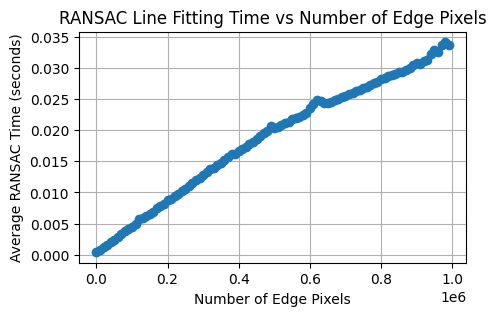

In [42]:
# Graficamos los resultados
plt.figure(figsize=(5, 3))
plt.plot(px_counts, avg_times, marker='o')
plt.title('RANSAC Line Fitting Time vs Number of Edge Pixels')
plt.xlabel('Number of Edge Pixels')
plt.ylabel('Average RANSAC Time (seconds)')
plt.grid()
plt.show()

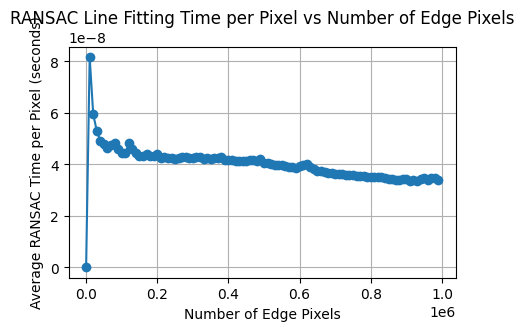

In [43]:
avg_exec_time_per_px_count = [t / pc if pc > 0 else 0 for t, pc in zip(avg_times, px_counts)]  
plt.figure(figsize=(5, 3))
plt.plot(px_counts, avg_exec_time_per_px_count, marker='o')
plt.title('RANSAC Line Fitting Time per Pixel vs Number of Edge Pixels')
plt.xlabel('Number of Edge Pixels')
plt.ylabel('Average RANSAC Time per Pixel (seconds)')
plt.grid()
plt.show()

Mirando a la gráfica, resulta evidente la relación lineal entre el número de píxeles y el tiempo de ejecución por iteración. En procesador AMD Ryzen 7 5800H se ha obtenido un tiempo de ejecución por iteración de $3\times10^{-8} s$ por píxel de borde. 

## 5.2. Análisis de la convergencia de RANSAC para rectas

Estudiar cuánto tarda en converger el algoritmo es algo más complicado ya que depende en mayor medida de los elementos que puedan estar presentes en la imagen. Para poder concluir cuántas iteraciones son necesarias para detectar una recta, vamos a escoger las imágenes de bordes 0 y 3, que cuentan con rectas largas, y vamos a hacer lo siguiente:
1. Establecemos max_iterations a 10.
2. Ejecutamos ransac 100 veces.
3. Almacenamos la tasa de éxito.
4. Multiplicamos max_iterations por 1'1.
5. Volvemos al paso 2.

Podemos repetir este procedimiento hasta obtener una tasa de éxito del 100%.

In [44]:
success_rates_mat = []
max_iterations_mat = []

for img, k in zip(borders, range(len(borders))):

    # Instanciamos el extractor de características con la imagen de bordes (binaria)
    feature_extractor = FeatureExtractor(edge_image=Image(data=img.astype(np.bool), rois=[],format=ImageFormat.BOOLEAN))

    success_rates = []
    max_iterations = []
    mi = 10
    sr = 0.0

    while sr < 0.90 and mi <= 1000:
        success_count = 0
        for i in range(0, 100):
            line = feature_extractor.ransac_line_fitting(
                max_iterations=mi,
                distance_threshold=1.0,
                min_inliers=150,
                max_lsq_iterations=0,
                erase=False
            )
            if (line is not None):
                success_count += 1
        sr = success_count / 100.0
        success_rates.append(sr)
        max_iterations.append(mi)
        mi = int(mi * 1.1)

    print(f"Processed image: {k} Max iterations = {mi}")

    success_rates_mat.append(success_rates)
    max_iterations_mat.append(max_iterations)

Processed image: 0 Max iterations = 455
Processed image: 1 Max iterations = 1069
Processed image: 2 Max iterations = 343
Processed image: 3 Max iterations = 500
Processed image: 4 Max iterations = 731
Processed image: 5 Max iterations = 1069
Processed image: 6 Max iterations = 972
Processed image: 7 Max iterations = 39
Processed image: 8 Max iterations = 550
Processed image: 9 Max iterations = 1069
Processed image: 10 Max iterations = 1069


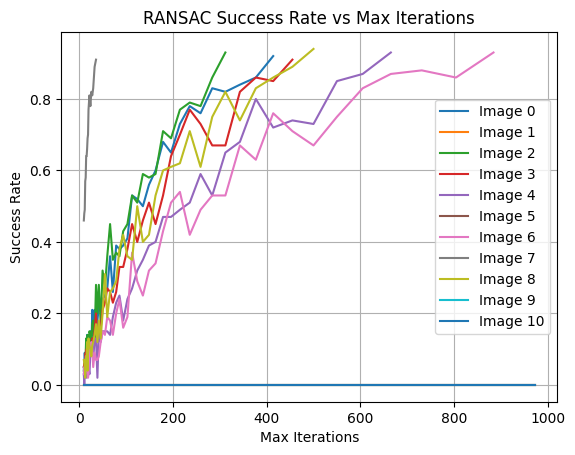

In [45]:
# plotting the success rates for each image
for i in range(len(borders)):
    plt.plot(max_iterations_mat[i], success_rates_mat[i], label=f'Image {i}')
plt.title('RANSAC Success Rate vs Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel('Success Rate')
plt.legend()
plt.grid()
plt.show()

Buscando una recta con 150 inliers, que para los rangos en los que estamos trabajando se considera un número alto, vemos como en las imágenes 7, 2, 8, 0 y 3 ransac encuentra dicha recta el 80% de las veces en menos de 400 iteraciones. Para los casos en los que no existe dicha recta, como en la imagen 1 o la imagen 10, la gráfica se muestra como se esperaba. 

En cualquier caso, en todas las imágenes en las que sí existe dicha recta parece encontrarse un 20% de las veces en las 100 primeras iteraciones. Este hecho nos va a ayudar a establecer un número mínimo de iteraciones necesario para detectar una recta. 

Sea $X$ la variable aleatoria que modela la cantidad de iteraciones necesarias para detectar una recta que cumpla las condiciones en el caso de que exista. $X$ sigue entonces una distribución binomial con probabilidad de éxito de $p=20\%/100 = 2\times 10^{-3}$. Entonces:
$P(X\leq n)=0.95 \Leftrightarrow 1-(1-p)^n > 0.95 \Leftrightarrow (1-2\times 10^{-3})^n > 0.05 \Leftrightarrow n\ln{(1-2\times 10^{-3})} > \ln{0.05} \Leftrightarrow n>1497$.

En conclusión, estableciendo el máximo de número de ejecuciones a 1500, en caso de que exista una recta que cumpla las condiciones que buscamos será encontrada el 95% de las veces. Para imágenes como las vistas en este ducumento, que cuentan con no más de 10000 píxeles de borde, y con el análisis previo podemos establecer un tiempo estimado para encontrar una recta de:

$$
3\times 10^{-8}\frac{s}{it}\times 1500 \frac{it}{recta} = 4.5\times 10^{-5} s \frac{s}{recta}
$$

Por tanto, el tiempo de cómputo estimado por recta es de 0.045 milisegundos, un tiempo más que asumible teniendo en cuenta las condiciones planteadas. Para usos posteriores se propone:
1. Comenzar un un número de inliers excesivo.
2. Aplicar RANSAC con 1500 iteraciones.
3. Si no se encuentra una recta, decrementar el número de inliers.
4. Repetir 2

Aun comenzando con 300 inliers (lo que correspondería a más o menos un tercio de la longitud de la imagen con la que trabajamos), estableciendo un decremento de 2 inliers por iteración y suponiendo que encontramos de media una recta por iteración hablamos un tiempo de cómputo de unos 6 milisegundos. Un tiempo corto aún procesando video en directo.

# 6. Conclusiones

A lo largo de este notebook hemos cubierto dos aplicaciones clásicas de RANSAC adaptándolas a las necesidades de nuestro problema. La detección de rectas en ventana deslizante y reforzada mediante segmentos han demostrado ser métodos más robustos ante el ruido y apropiados para la detección de los objetos más pequeños de las imágenes de tráfico. La detección de círculos, aunque efectiva para su propósito, es sensible a los cambios de perspectiva. Otra aportación clave es la idea de utilizar el espacio HSV para aprovechar las propiedades de las señales de tráfico. Consideramos que la inclusión de estas herramientas en pipelines de deep learning puede ayudarnos en futuras entregas.

Hemos cubierto los siguientes ítems:

* BT2a - RANSAC/HT para rectas.
* BT2d - RANSAC/HT para círculos.
* BT2e - Detección multi-instancia.
* BT2g/BT2h - Modelo geométrico más complejo/Cualquier otro uso razonable de HT o RANSAC:

    Creemos que la detección de segmentos es una mejora que puede encajar en alguna de estas categorías.
* BT2i - Programación de HT/RANSAC manual.

    Aunque no hemos realizado la comparación con métodos de librería, creemos que nuestra implementación puede ser lo suficientemente buena como para encajar en este punto.


# Uso de IA

Para la elaboración de este trabajo se ha utilizado IA conversacional para asistir en la elaboración del código y entendimiento de los algoritmos implementados.

## Bibliografía

[1] Open Source Computer Vision Library, “Geometric Image Transformations,” in OpenCV 3.4.20-dev Documentation, [En línea]. Disponible: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html [Consultado: 02-Nov-2025]

[2] [Canny, J. (1986)](https://doi.org/10.1109/TPAMI.1986.4767851). *A Computational Approach to Edge Detection.* **IEEE Transactions on Pattern Analysis and Machine Intelligence**, vol. PAMI-8, no. 6, pp. 679–698, Nov. 1986.

[3] Wikipedia, "Modelo de color HSV", Wikipedia, la enciclopedia libre, [En línea]. Disponible: https://es.wikipedia.org/wiki/Modelo_de_color_HSV. [Consultado: 30-Oct-2025].
